In [1]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt

from torchqc.states import QuantumState
from torchqc.common_functions import get_density_matrix, expect_val_dm
from torchqc.operators import Operator
from torchqc.common_matrices import sigmaZ, annihilation, creation, eye, sigmaPlus, sigmaMinus
from torchqc.dynamics import lindblad_equation
from torchqc.tensor_product import tensor_product_ops, tensor_product_states

In [2]:
n = 2 # two level atom
N = 50 # number of fock states
total_dims = n * N
basis_states = QuantumState.basis(n)
atom_state = basis_states[0]

b = np.sqrt(20)
coherent_state_plus_b = QuantumState.coherent(N, b)
coherent_state_minus_b = QuantumState.coherent(N, -b)
cat_state = (coherent_state_plus_b + coherent_state_minus_b)
cat_state.normalize()

initial_state = tensor_product_states(cat_state, atom_state)

* Simulate dynamics

In [3]:
T = 40
Dt = 0.1
wc = 0.1  # cavity frequency
wa = 0.1  # atom frequency
g = 1  # coupling strength
time = np.arange(0, T, Dt, dtype = np.float32)

* Jaynes-Cummings Hamiltonian under RWA

In [4]:
a_dagger = creation(N)
a = annihilation(N)
sigmap = sigmaPlus()
sigmam = sigmaMinus()

H1 = tensor_product_ops(eye(N), -(wa / 2) * sigmaZ())
H2 = tensor_product_ops(wc * a_dagger * a, eye(n))
H3 = g * (tensor_product_ops(a, sigmap) + tensor_product_ops(a_dagger, sigmam))

H = H1 + H2 + H3

In [5]:
matrices = H.matrix.expand(len(time), -1, -1)
hamiltonian = Operator(total_dims, matrices)

* Simulate dynamics with von-Neumann equations

In [6]:
rho = get_density_matrix(initial_state)
time_tensor, states = lindblad_equation(rho, hamiltonian, time, Dt)

In [7]:
N_op = a_dagger * a
expectation_values = expect_val_dm(states, tensor_product_ops(eye(N), sigmaZ()))
expectation_values2 = expect_val_dm(states, tensor_product_ops(N_op, eye(n)))

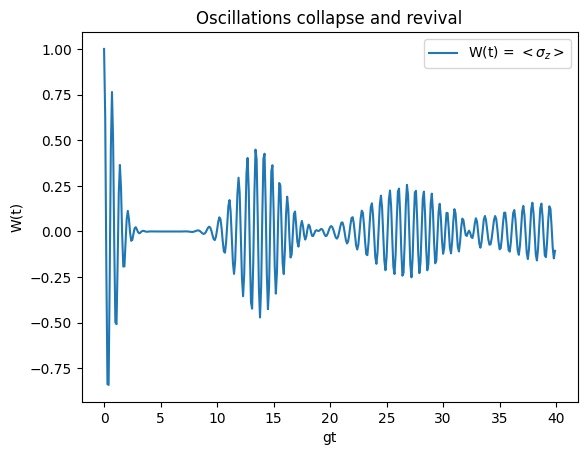

In [8]:
fig, ax = plt.subplots()

plt.plot(time, expectation_values, label=r"W(t) = $<\sigma_z>$")
plt.xlabel("gt")
plt.ylabel("W(t)")
plt.title("Oscillations collapse and revival")
ax.legend()